In [7]:
import pandas as pd
import numpy as np
import sklearn
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from scipy import signal

In [2]:
trainX = pd.read_csv("data/X_train.csv").drop(columns=["id"])
trainy = pd.read_csv("data/y_train.csv").drop(columns=["id"])
testX = pd.read_csv("data/X_test.csv").drop(columns=["id"])

In [3]:
def removeNans(data):
    trainX_aug = []
    for i in tqdm.trange(0,len(data)):
        lastIdx = data.iloc[i].index.get_loc(data.iloc[i,:].last_valid_index())
        trainX_aug.append(data.iloc[i,0:lastIdx])
    trainX_aug = np.array(trainX_aug)
    return trainX_aug

In [4]:
new_trainX = removeNans(trainX)

100%|██████████████████████████████████████████████████████████████████████████████| 5117/5117 [04:40<00:00, 18.27it/s]
<ipython-input-3-6cf82b3ee46d>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trainX_aug = np.array(trainX_aug)


# Applying the Fourier Transform

In [ ]:
def removeNans(data):
    trainX_aug = []
    for i in tqdm.trange(0,len(data)):
        lastIdx = data.iloc[i].index.get_loc(data.iloc[i,:].last_valid_index())
        trainX_aug.append(data.iloc[i,0:lastIdx])
    trainX_aug = np.array(trainX_aug)
    return trainX_aug

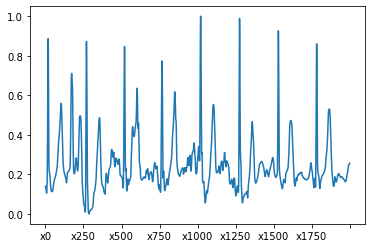

1000


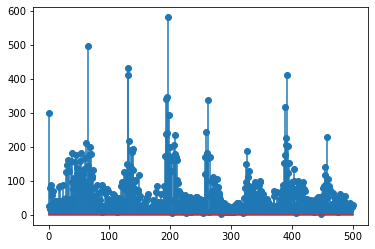

(500,)
[301.308       24.94596193  79.48425459  17.10727387  86.62028219
  29.59255774  59.89845488  32.61994801  69.67329023  24.52014823
  40.18285332  21.00997954  38.18980274  37.72246419  41.21947568
  14.4199604   17.75745332  81.20290571  15.66859433  84.26539715
  21.75752495  41.17072924  22.81263331  41.94454135  88.35701549
  46.82614065  41.78274053  12.87029297  51.2202983  127.28960772
 146.28838557  36.19574312 161.42739293 127.89619608  15.96335234
  29.45600782  45.37772913 159.85265704  97.55707809 181.46451812
  77.33278875  40.69502168 108.38277852 156.80961733  51.66057275
 177.55298132 139.37210003 120.71976261 107.90836929  88.64246754
 116.09770836  96.10936653 159.63581414 181.85016794  82.12943376
 121.88463074 120.81480754 101.94960523 135.82076031  95.76493557
 166.49122177  56.86539649 212.03294596  80.2520916  145.25049
 496.68990391 175.9120786   84.64794762 200.86149464 123.44125726
 178.27111169 115.15452569 109.50027396 131.41482448  37.5172744
  78.60

In [97]:
from scipy import fftpack

Fs = 300
t = np.arange(0,1,1/Fs)

maxVal = trainX.iloc[0,0:2000].max()
minVal = trainX.iloc[0,0:2000].min()
norm = (trainX.iloc[0,0:2000]-minVal)/ (maxVal-minVal) 

norm.plot()
plt.show()

fft = fftpack.fft(np.array(trainX.iloc[0,0:16278]))

n = np.size(t)
print(n)
fr = Fs/2 * np.linspace(0,1,n//2)
y_m = 2/n * abs(fft[0:np.size(fr)])

plt.stem(fr,y_m)
plt.show()

print(fr.shape)
print(y_m)

In [151]:
def fft(data, fs=300):
    Fs = fs
    t = np.arange(0,1,1/Fs)
    fft = fftpack.fft(np.array(data))
    n = np.size(t)
    fr = Fs/2 * np.linspace(0,1,n//2)
    y_m = 2/n * abs(fft[0:np.size(fr)])
    return fr,y_m

In [134]:
import tqdm
fft_trainX = []
for i in tqdm.trange(0,len(trainX)):
    lastIdx = trainX.iloc[i].index.get_loc(trainX.iloc[i,:].last_valid_index())
    fft_trainX.append(fft(trainX.iloc[i,0:lastIdx]))

fft_trainX = np.array(fft_trainX)
print(fft_trainX.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 5117/5117 [04:53<00:00, 17.44it/s]


(5117, 2, 500)


# Short Time Fourier Transform

In [5]:
import neurokit2 as nk

signals = pd.DataFrame()
for i in tqdm.trange(0,len(new_trainX)):
    signals = signals.append({"ECG_BioSPPy" : nk.ecg_clean(new_trainX[i], sampling_rate=300, method="biosppy")},ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 5117/5117 [02:19<00:00, 36.63it/s]


In [124]:
stft_trainX = []
for i in tqdm.trange(0,len(signals)):
    f, t, stft = nk.signal_timefrequency(signals.iloc[i,0], 300, max_frequency=20, method="stft", window=8, overlap=10 , show=False)
    stft_trainX.append(stft)

100%|█████████████████████████████████████████████████████████████████████████████| 5117/5117 [00:07<00:00, 696.51it/s]


In [164]:
from scipy import fftpack

fft_trainX = []
for i in tqdm.trange(0,len(signals)):
    _,y = fft(signals.iloc[i,0],300)
    fft_trainX.append(y)
print(len(fft_trainX),len(fft_trainX[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 5117/5117 [00:12<00:00, 418.72it/s]

5117 150


In [98]:
stft_trainX = np.reshape(stft_trainX,(len(stft_trainX),len(stft_trainX[0])*len(stft_trainX[0][0])))
print(stft_trainX.shape)

C:\Users\atace\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


ValueError: could not broadcast input array from shape (160,7) into shape (160,)

# Training

In [165]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score , make_scorer

f1 = make_scorer(f1_score,average="micro")

randomForest = RandomForestClassifier()

In [166]:
print(cross_val_score(randomForest, fft_trainX, trainy.values.ravel(), cv=5, scoring=f1, n_jobs=-1, verbose=2))
# The results are around 0.60 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.8s remaining:   25.2s


[0.60839844 0.61328125 0.61192571 0.61192571 0.60703812]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished
